In [1]:
!pip install scikit-learn==1.7.0
!pip install xgboost==3.0.2
!pip install catboost==1.2.8


  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl (10.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 1.3.1 requires networkx<4,>=3.0, but you have networkx 2.8.8 which is incompatible.
autogluon-core 1.3.1 requires scikit-learn<1.7.0,>=1.4.0, but you have scikit-learn 1.7.0 which is incompatible.
autogluon-features 1.3.1 requires scikit-learn<1.7.0,>=1.4.0, but you have scikit-learn 1.7.0 which is incompatible.
autogluon-tabular 1.3.1 requires networkx<4,>=3.0, but you have networkx 2.8.8 which is incompatible.
autogluon-tabular 1.3.1 requires scikit-learn<1.7.0,>=1.4.0, but you have scikit-learn 1.7.0 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [2]:
!pip install -U imbalanced-learn


  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 1.3.1 requires networkx<4,>=3.0, but you have networkx 2.8.8 which is incompatible.
autogluon-tabular 1.3.1 requires networkx<4,>=3.0, but you have networkx 2.8.8 which is incompatible.


训练集样本: (1151, 655), 测试集样本: (288, 655)
各类别样本数：
printability_label
1    877
0    274
Name: count, dtype: int64

各类别占比（%）：
printability_label
1    76.19
0    23.81
Name: proportion, dtype: float64


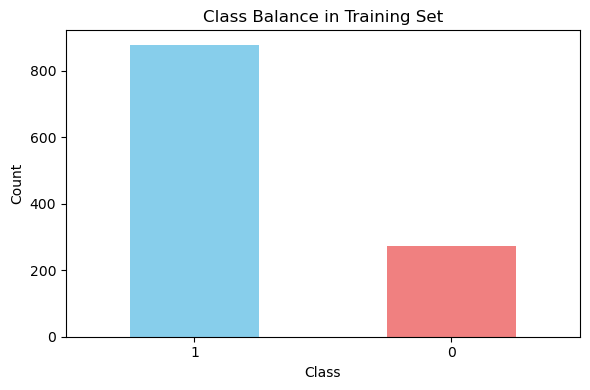

[0]	train-logloss:0.84465	test-logloss:0.54405
[100]	train-logloss:0.48987	test-logloss:0.47425
[200]	train-logloss:0.39660	test-logloss:0.46627
[300]	train-logloss:0.35035	test-logloss:0.45604
[400]	train-logloss:0.31948	test-logloss:0.44291
[500]	train-logloss:0.29559	test-logloss:0.43290
[600]	train-logloss:0.27498	test-logloss:0.42211
[700]	train-logloss:0.25917	test-logloss:0.41444
[800]	train-logloss:0.24521	test-logloss:0.40713
[900]	train-logloss:0.23234	test-logloss:0.39968
[1000]	train-logloss:0.22162	test-logloss:0.39498
[1100]	train-logloss:0.21233	test-logloss:0.39108
[1200]	train-logloss:0.20323	test-logloss:0.38815
[1213]	train-logloss:0.20229	test-logloss:0.38811
自动找到最佳 F1 阈值为: 0.3728, 对应 F1: 0.6711
Accuracy: 0.8229
ROC-AUC: 0.8551
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        68
           1       0.91      0.85      0.88       220

    accuracy                           0.82       288
 

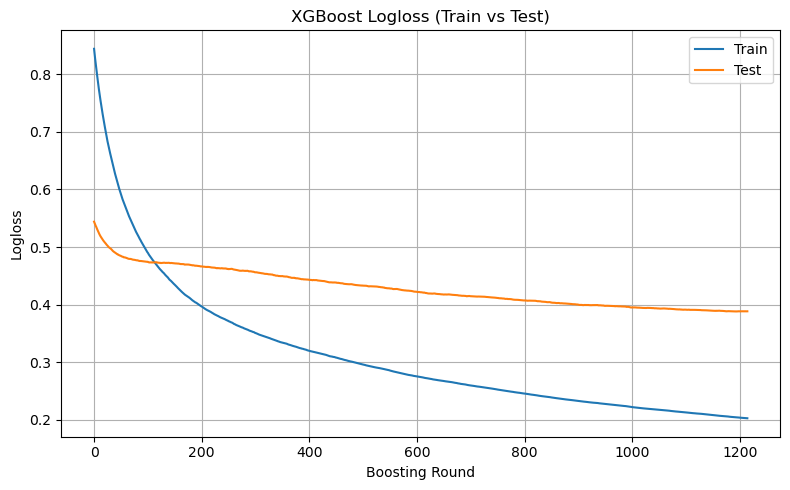

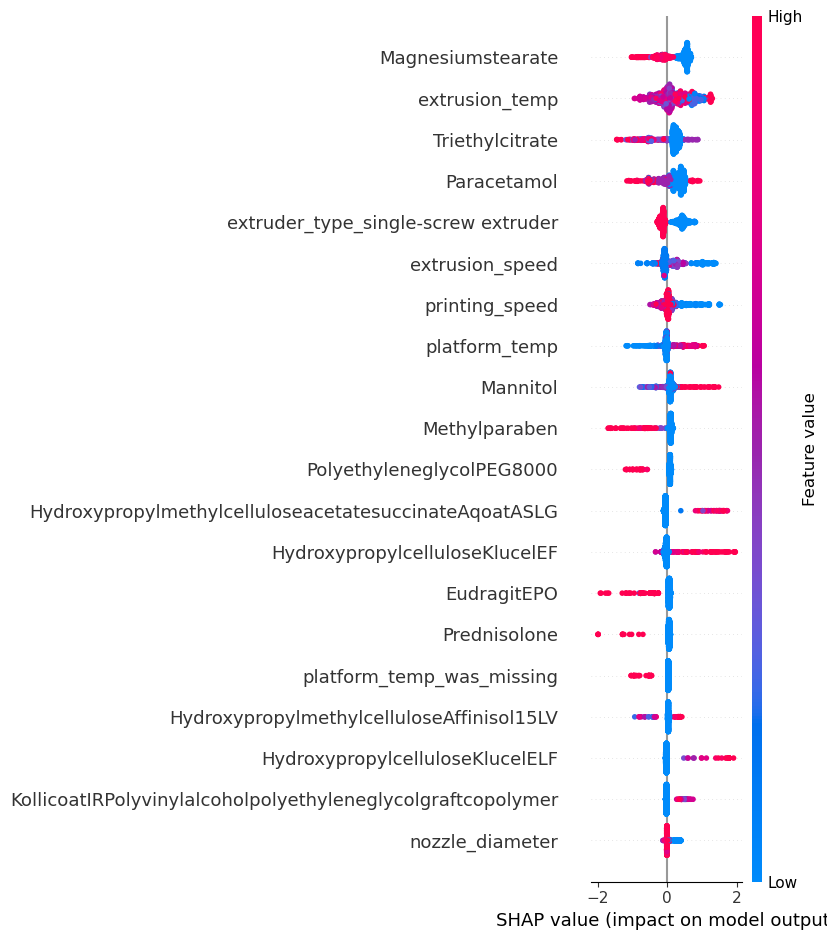

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE

# 1. 读入数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.9_datasets\original_dataset.xlsx")
# 2. 删除不需要的列
drop_cols = ['article']
df = df.drop(columns=drop_cols)

# 2. 丢弃缺失超过 50% 的列
df = df.dropna(axis=1, thresh=int(len(df)*0.5)).copy()

# 3. 处理目标变量，并筛除填充后仍为 'unknown' 的行
df['printability'] = df['printability'].fillna('unknown')
df = df[df['printability'] != 'unknown'].reset_index(drop=True)
df['printability_label'] = df['printability'].map({'yes': 1, 'no': 0})

# 4. 分离特征和标签
y = df['printability_label']
X = df.drop(columns=['printability', 'printability_label'])

# 5. 生成 missing indicators
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
missing_flags = pd.DataFrame({f"{c}_was_missing": X[c].isna().astype(int) for c in num_cols})
X = pd.concat([X, missing_flags], axis=1)

# 6. 填补缺失：数值填 0，类别填 'missing'
X[num_cols] = X[num_cols].fillna(0)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X[cat_cols] = X[cat_cols].fillna('missing')

# 7. 先划分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"训练集样本: {X_train.shape}, 测试集样本: {X_test.shape}")


#--------------------------------------------------------------------------

# 1. 样本数统计
counts = y_train.value_counts()
print("各类别样本数：")
print(counts)

# 2. 样本占比
pct = y_train.value_counts(normalize=True) * 100
print("\n各类别占比（%）：")
print(pct.round(2))

# 3. 柱状图可视化
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Class Balance in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8. 类别变量 One-Hot 编码
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test, drop_first=True)
# 对齐列（训练集中没有的补 0）
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
cols = X_train_enc.columns.tolist()

# 9. 数值标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)

# 10. 处理类别不平衡（可选 SMOTE，也可以只用 scale_pos_weight）
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# 11. 构造 DMatrix
dtrain = xgb.DMatrix(X_res, label=y_res)
dtest  = xgb.DMatrix(X_test_scaled, label=y_test)

# 12. 计算 scale_pos_weight（若只用 weight 不用 SMOTE）
#neg, pos = np.bincount(y_train)
#if pos == 0:
   # raise ValueError("训练集中没有正例！")
#scale_pos_weight = neg / pos

# 13. XGBoost 参数 & 训练
params = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'base_score': y_train.mean(),
    #'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss'
}
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=100
)

# 14. 评估
from sklearn.metrics import precision_recall_curve
y_pred_proba = model.predict(dtest)
# 概率转成 class=0 的置信度（因为 F1 是以 class=0 为主评估对象）
probs_0 = 1 - y_pred_proba

# 计算 PR 曲线
prec, rec, thr = precision_recall_curve((y_test == 0).astype(int), probs_0)

# 计算每个阈值下的 F1
f1 = 2 * prec * rec / (prec + rec + 1e-20)
best_idx = f1.argmax()
best_thr = thr[best_idx]

print(f"自动找到最佳 F1 阈值为: {best_thr:.4f}, 对应 F1: {f1[best_idx]:.4f}")

# 用这个最佳阈值分类
y_pred_label = np.where(probs_0 > best_thr, 0, 1)

print(f"Accuracy: {accuracy_score(y_test, y_pred_label):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_label))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_label))

# 15. 绘制 Logloss 曲线
epochs = len(evals_result['train']['logloss'])
x_axis = range(epochs)
plt.figure(figsize=(8,5))
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.plot(x_axis, evals_result['test']['logloss'],  label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss (Train vs Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=X_train_enc.columns)

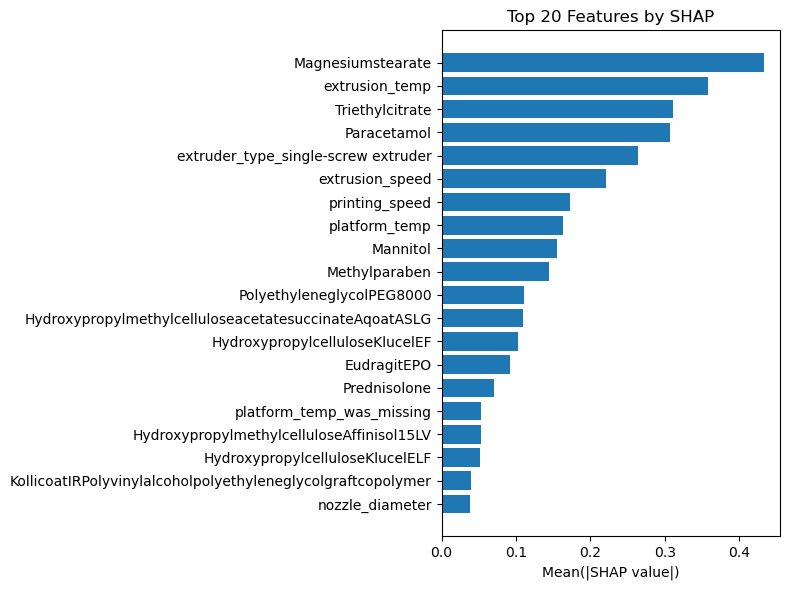

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 平均每个特征的SHAP绝对值（越大越重要）
mean_shap = np.abs(shap_values).mean(axis=0)

# 构造DataFrame，便于排序和展示
shap_df = pd.DataFrame({
    'feature': cols,  
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# 取 Top 70 特征
shap_top_70 = shap_df.head(70)
shap_top_features = shap_top_70['feature'].tolist()

# 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(shap_top_70['feature'][:20][::-1], shap_top_70['mean_abs_shap'][:20][::-1])
plt.title("Top 20 Features by SHAP")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

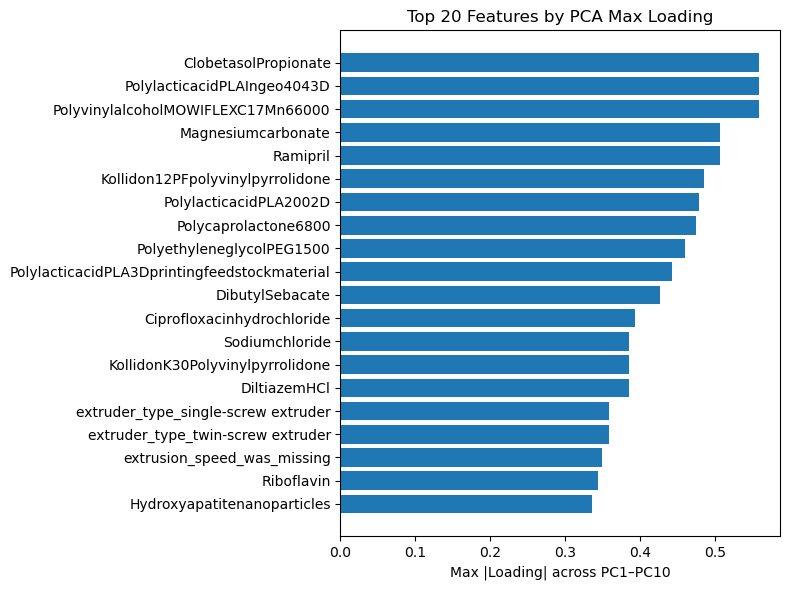

In [5]:
from sklearn.decomposition import PCA

# 设置保留主成分个数
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_scaled)

# 获取每个主成分对应的所有特征 loading
loadings = np.abs(pca.components_)  

# 计算每个特征在所有主成分中的“最大 loading”
max_loading_per_feature = loadings.max(axis=0)

# 映射回特征名
pca_df = pd.DataFrame({
    'feature': cols,
    'max_loading': max_loading_per_feature
}).sort_values(by='max_loading', ascending=False)

# 取 Top 70 特征
pca_top_70 = pca_df.head(70)
pca_top_features = pca_top_70['feature'].tolist()

# 可视化 Top 20 特征的 loading 值
plt.figure(figsize=(8, 6))
plt.barh(pca_top_70['feature'][:20][::-1], pca_top_70['max_loading'][:20][::-1])
plt.title("Top 20 Features by PCA Max Loading")
plt.xlabel("Max |Loading| across PC1–PC10")
plt.tight_layout()
plt.show()


Epoch 0 - Loss: 0.6317, Attention: μ=0.0015, σ=0.0008
Epoch 10 - Loss: 0.1391, Attention: μ=0.0015, σ=0.0332
Epoch 20 - Loss: 0.0518, Attention: μ=0.0015, σ=0.0337
Epoch 30 - Loss: 0.0695, Attention: μ=0.0015, σ=0.0338
Epoch 40 - Loss: 0.0465, Attention: μ=0.0015, σ=0.0340


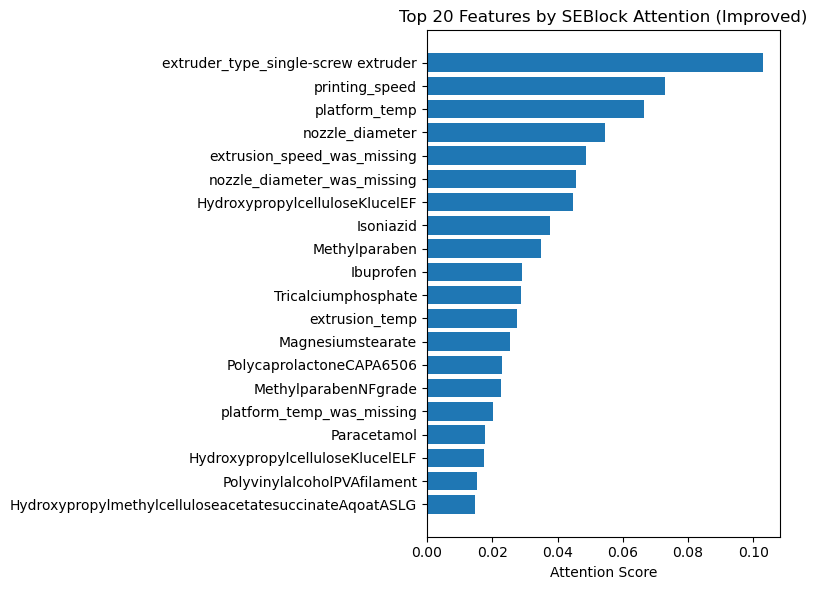

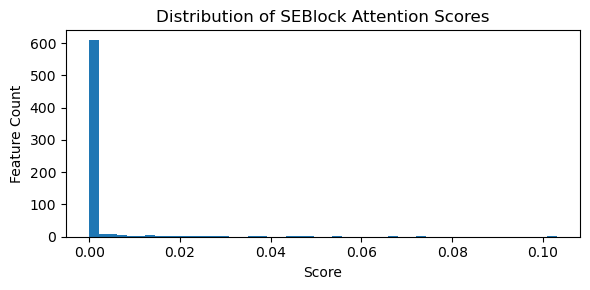

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 转换为 PyTorch 格式
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 改进版 SEBlock 模型：用 Softmax 做特征级注意力归一化
class SEBlockMLP(nn.Module):
    def __init__(self, input_dim):
        super(SEBlockMLP, self).__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)  # 改成 Softmax，特征间相对权重
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
#self.classifier 是一个简单的 2 层 MLP，用于分类
    
    def forward(self, x):
        weights = self.se(x)           # 输出每个特征的注意力分数
        x_weighted = x * weights       # 加权后的特征输入分类器
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = SEBlockMLP(X_train_scaled.shape[1])
neg, pos = np.bincount(y.values)
pos_weight = torch.tensor([neg / pos], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            _, weights = model(X_tensor)
            mean_score = weights.mean().item()
            std_score = weights.std().item()
            print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Attention: μ={mean_score:.4f}, σ={std_score:.4f}")

# 5. 提取注意力特征得分（取均值）
with torch.no_grad():
    _, final_weights = model(X_tensor)
    feature_scores = final_weights.mean(dim=0).numpy()

#这一步提取的是所有样本中每个特征的平均注意力分数（作为特征重要性）；
#转换为 NumPy 后用于可视化/排序。

# 6. 构造 DataFrame
se_df = pd.DataFrame({
    'feature': cols,
    'attention_score': feature_scores
}).sort_values(by='attention_score', ascending=False)

# 7. 取 Top 70 特征
se_top_70 = se_df.head(70)
se_top_features = se_top_70['feature'].tolist()

# 8. 可视化 Top 20
plt.figure(figsize=(8, 6))
plt.barh(se_top_70['feature'][:20][::-1], se_top_70['attention_score'][:20][::-1])
plt.title("Top 20 Features by SEBlock Attention (Improved)")
plt.xlabel("Attention Score")
plt.tight_layout()
plt.show()

# 9. 可视化全部注意力分数分布（辅助判断是否有效区分）
plt.figure(figsize=(6, 3))
plt.hist(feature_scores, bins=50)
plt.title("Distribution of SEBlock Attention Scores")
plt.xlabel("Score")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()

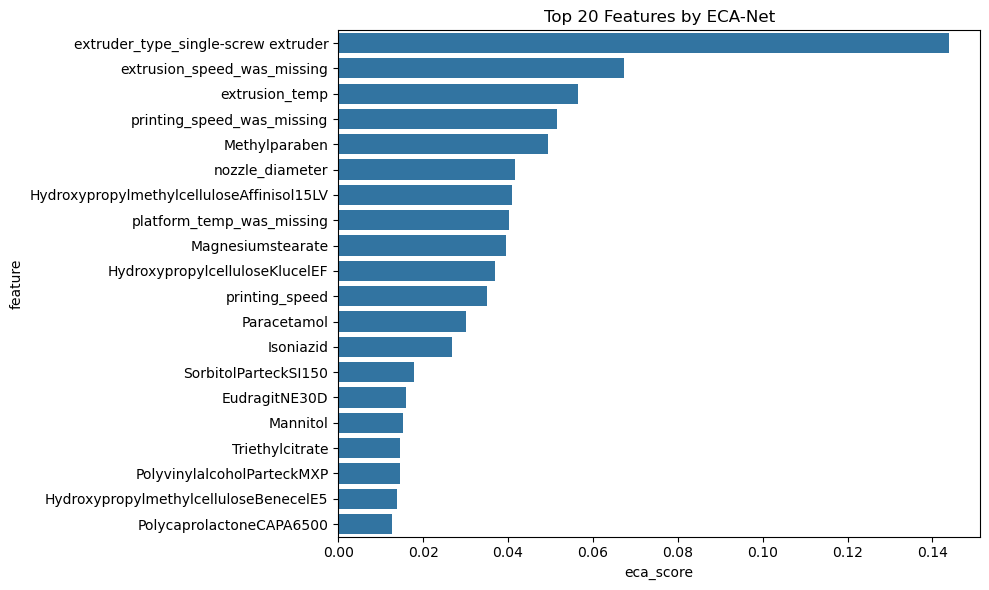

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

# 1. 转换为 PyTorch 张量
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. 定义 ECA-Net 结构
class ECABlockMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.se(x)
        x_weighted = x * weights
        out = self.classifier(x_weighted)
        return out, weights

# 3. 初始化模型
model = ECABlockMLP(X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练模型
for epoch in range(50):
    for xb, yb in loader:
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 5. 提取特征权重
with torch.no_grad():
    _, weights = model(X_tensor)
    attention_score = weights.mean(dim=0).numpy()

# 6. 保存成 DataFrame
eca_df = pd.DataFrame({
    'feature': cols,
    'eca_score': attention_score
}).sort_values(by='eca_score', ascending=False)

# 7. 取 Top 70 特征名列表
eca_top_70 = eca_df.head(70)
eca_top_features = eca_top_70['feature'].tolist()

# 8. 可视化 Top 20
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', x='eca_score', data=eca_top_70.head(20))
plt.title("Top 20 Features by ECA-Net")
plt.tight_layout()
plt.show()


出现在 ≥2 个方法中的特征数：74
[0]	train-logloss:0.84532	test-logloss:0.54403
[100]	train-logloss:0.51668	test-logloss:0.48393
[200]	train-logloss:0.42891	test-logloss:0.47652
[300]	train-logloss:0.38538	test-logloss:0.46727
[400]	train-logloss:0.35114	test-logloss:0.45361
[500]	train-logloss:0.32489	test-logloss:0.44092
[600]	train-logloss:0.30241	test-logloss:0.42979
[700]	train-logloss:0.28435	test-logloss:0.42111
[800]	train-logloss:0.26873	test-logloss:0.41472
[900]	train-logloss:0.25454	test-logloss:0.40799
[1000]	train-logloss:0.24241	test-logloss:0.40293
[1018]	train-logloss:0.23977	test-logloss:0.40306
Accuracy: 0.8299
AUC: 0.8461
LogLoss: 0.4032
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65        68
           1       0.89      0.88      0.89       220

    accuracy                           0.83       288
   macro avg       0.76      0.77      0.77       288
weighted avg       0.83      0.83      0.83       288

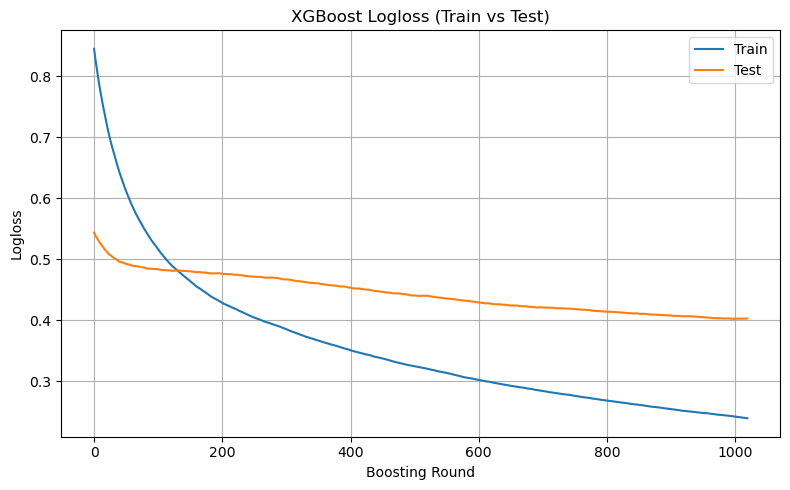

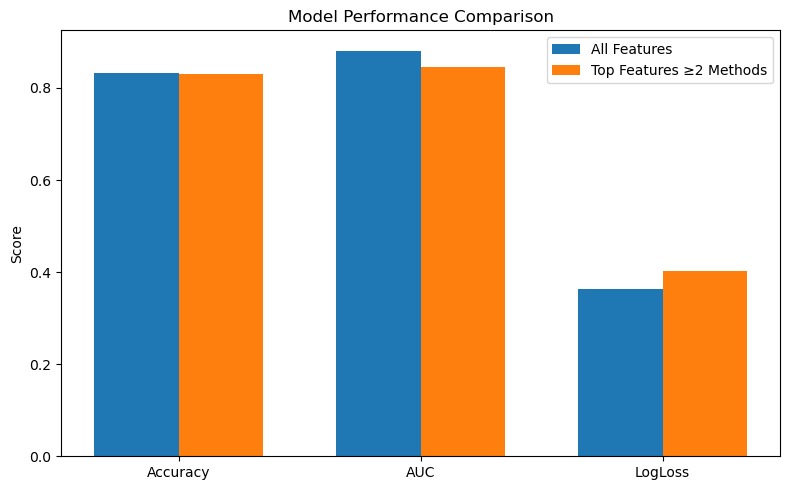

特征数量对比：全特征 = 656，筛选特征 = 74


In [8]:
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# 1. 构造“出现次数≥2”的特征子集
all_top_features = shap_top_features + pca_top_features + se_top_features + eca_top_features
feature_counter = Counter(all_top_features)

# 2. 筛选出现 ≥2 次的特征
selected_features = [feat for feat, count in feature_counter.items() if count >= 2]
print(f"出现在 ≥2 个方法中的特征数：{len(selected_features)}")

# 注意：X_train_enc 和 X_test_enc 是第一次划分之后做的 One-Hot 编码结果
X_selected_train = X_train_enc[selected_features]
X_selected_test = X_test_enc[selected_features]

# 标准化
scaler = StandardScaler()
X_selected_train_scaled = scaler.fit_transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)
# SMOTE 仅作用于训练集
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_selected_train_scaled, y_train)

# 构造 DMatrix
dtrain = xgb.DMatrix(X_res, label=y_res)
dtest = xgb.DMatrix(X_selected_test_scaled, label=y_test)

params = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'base_score': y_train.mean(),
    'eval_metric': 'logloss'
}

evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=100
)


y_pred_proba = model.predict(dtest)
y_pred_label = (y_pred_proba >= 0.5).astype(int)

acc_sel = accuracy_score(y_test, y_pred_label)
auc_sel = roc_auc_score(y_test, y_pred_proba)
roc_sel = roc_auc_score(y_test, y_pred_proba)
logloss_sel = log_loss(y_test, y_pred_proba)


# 模型评估输出
print(f"Accuracy: {acc_sel:.4f}")
print(f"AUC: {auc_sel:.4f}")
print(f"LogLoss: {logloss_sel:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_label))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_label))

# logloss曲线
epochs = len(evals_result['train']['logloss'])
plt.figure(figsize=(8,5))
plt.plot(range(epochs), evals_result['train']['logloss'], label='Train')
plt.plot(range(epochs), evals_result['test']['logloss'], label='Test')
plt.xlabel("Boosting Round")
plt.ylabel("Logloss")
plt.title("XGBoost Logloss (Train vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. 可视化性能对比
acc_full = 0.8322
auc_full = 0.8811
logloss_full = 0.36403
n_feat_full = X_train_enc.shape[1]
n_feat_sel = len(selected_features)

metrics = ['Accuracy', 'AUC', 'LogLoss']
full_model = [acc_full, auc_full, logloss_full]
sel_model = [acc_sel, auc_sel, logloss_sel]

x = np.arange(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, full_model, width=bar_width, label='All Features')
plt.bar(x + bar_width, sel_model, width=bar_width, label='Top Features ≥2 Methods')
plt.xticks(x + bar_width / 2, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()
print(f"特征数量对比：全特征 = {n_feat_full}，筛选特征 = {n_feat_sel}")

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

,Model,Accuracy,AUC,F1 Score,Precision,Recall
1,Random Forest,0.82623,0.85899,0.88981,0.86155,0.92019
4,SVM,0.81665,0.78129,0.88929,0.82412,0.96579
0,XGBClassifier,0.81755,0.83031,0.88441,0.85560,0.91562
2,KNN,0.81666,0.77216,0.88428,0.85216,0.91906
3,Logistic Regression,0.81319,0.78546,0.88425,0.83705,0.93730
5,CatBoost,0.80624,0.82142,0.88238,0.82061,0.95438


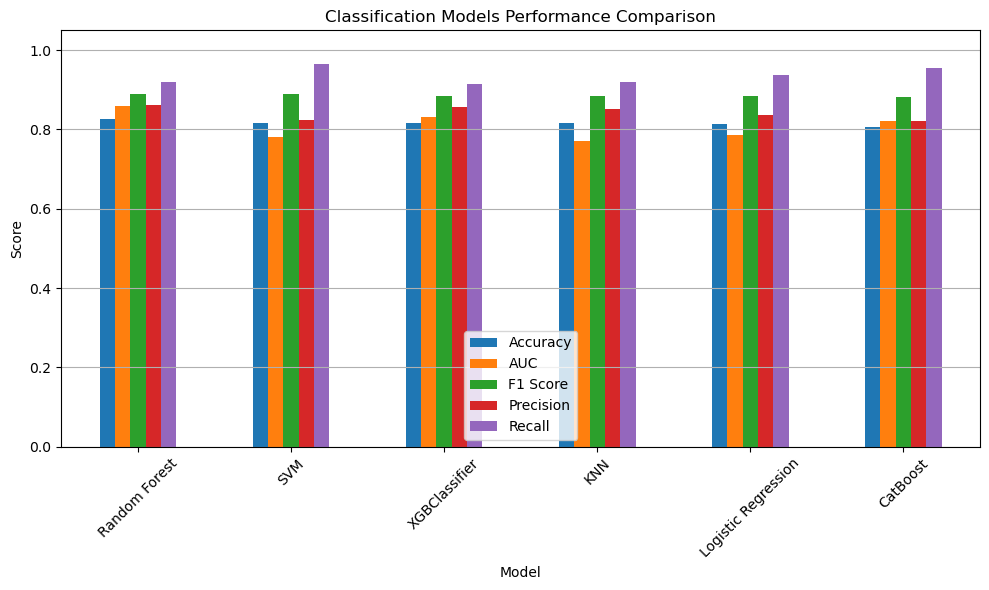

In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# 创建交叉验证器
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义模型
models = {
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# 存储结果
results = []

for name, model in models.items():
    acc = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='roc_auc').mean()
    f1 = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='f1').mean()
    precision = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X_selected_train_scaled, y_train, cv=cv, scoring='recall').mean()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# 结果展示
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='F1 Score', ascending=False)
df_results_sorted.set_index("Model")[["Accuracy", "AUC", "F1 Score", "Precision", "Recall"]].plot(
    kind='bar', figsize=(10, 6)
)
plt.title("Classification Models Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

from IPython.display import display
# 仅格式化数值列
display(
    df_results_sorted.style
        .set_caption("Classification Model Performance")
        .format({col: "{:.5f}" for col in df_results_sorted.columns if df_results_sorted[col].dtype != "object"})
)


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:31:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

,Model,Accuracy,AUC,F1 Score,Precision,Recall
1,Random Forest,0.82885,0.86914,0.89358,0.84916,0.94299
5,CatBoost,0.81060,0.81556,0.88646,0.81601,0.97037
0,XGBClassifier,0.81755,0.83071,0.88380,0.85927,0.90993
3,Logistic Regression,0.80275,0.76308,0.87634,0.83944,0.91676
4,SVM,0.78626,0.77495,0.87346,0.79571,0.96806
2,KNN,0.78797,0.76006,0.86835,0.82398,0.91788


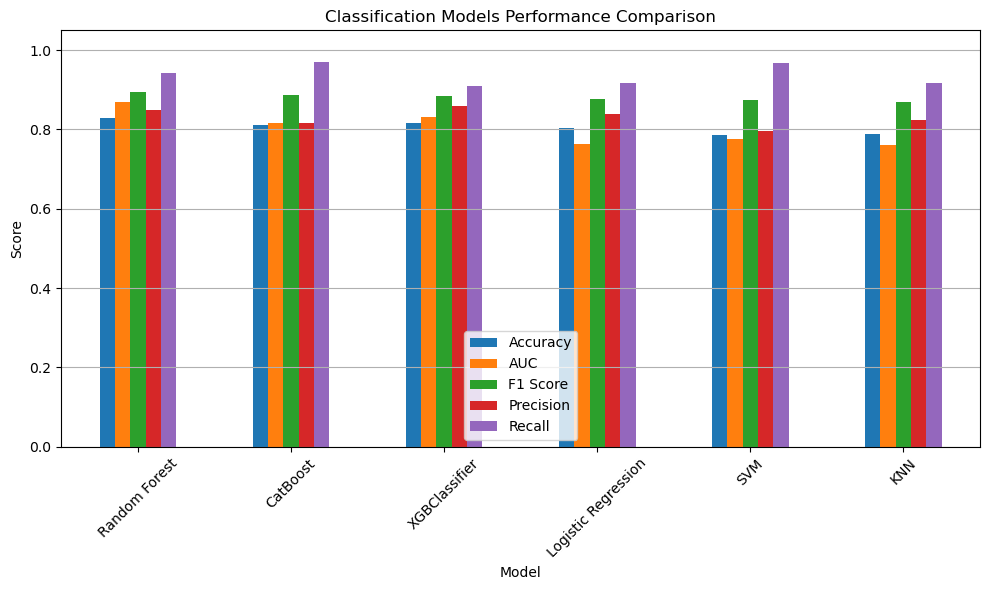

In [10]:
# 定义模型
models = {
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# 存储结果
results = []

for name, model in models.items():
    acc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc').mean()
    f1 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1').mean()
    precision = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='recall').mean()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# 结果展示
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='F1 Score', ascending=False)
df_results_sorted.set_index("Model")[["Accuracy", "AUC", "F1 Score", "Precision", "Recall"]].plot(
    kind='bar', figsize=(10, 6)
)
plt.title("Classification Models Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

from IPython.display import display
# 仅格式化数值列
display(
    df_results_sorted.style
        .set_caption("Classification Model Performance")
        .format({col: "{:.5f}" for col in df_results_sorted.columns if df_results_sorted[col].dtype != "object"})
)


In [11]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 定义交叉验证器
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

In [12]:
# 1️⃣ CatBoost
param_catboost = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}
model_cat = CatBoostClassifier(verbose=0, random_state=42)
search_cat = RandomizedSearchCV(
    model_cat,
    param_distributions=param_catboost,
    n_iter=20,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=1,  # ✅ 禁用并行，避免 pickle 报错
    random_state=42
)


search_cat.fit(X_selected_train_scaled, y_train)
print("Best Params:", search_cat.best_params_)
print("Best F1 Score:", search_cat.best_score_)

Best Params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 6}
Best F1 Score: 0.8889085739985967


In [13]:
# 2️⃣ Random Forest
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
model_rf = RandomForestClassifier(random_state=42)
search_rf = RandomizedSearchCV(
    model_rf,
    param_distributions=param_rf,
    n_iter=20,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=1,  # ✅ 强制单线程，防止所有 broken process 报错
    random_state=42
)

search_rf.fit(X_selected_train_scaled, y_train)
print("Best Params:", search_rf.best_params_)
print("Best F1 Score:", search_rf.best_score_)


Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best F1 Score: 0.8928412622400262


In [14]:
# 3️⃣ XGBoost
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
search_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_xgb,
    n_iter=20,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=1,  # ✅ 强制单线程防止 joblib 并行失败
    random_state=42
)

search_xgb.fit(X_selected_train_scaled, y_train)
print("Best Params:", search_xgb.best_params_)
print("Best F1 Score:", search_xgb.best_score_)

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best F1 Score: 0.8854301763676631


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,AUC,F1 Score,Precision,Recall
0,CatBoost,0.857639,0.851638,0.910284,0.877637,0.945455
1,RandomForest,0.847222,0.875769,0.906383,0.852000,0.968182
2,XGBClassifier,0.826389,0.844786,0.892241,0.848361,0.940909


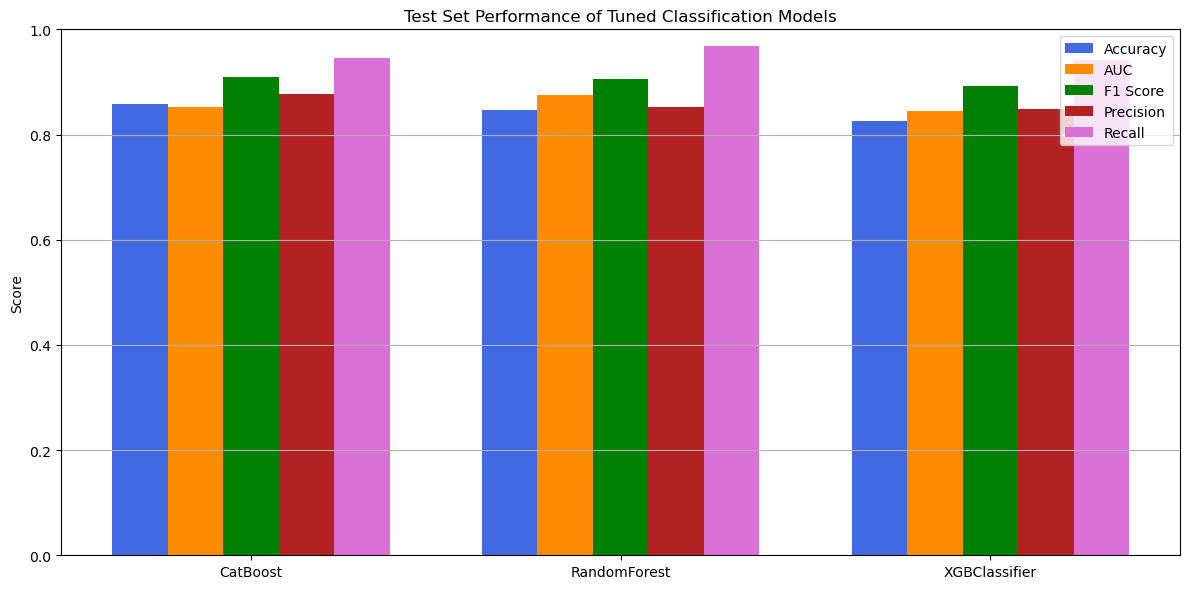

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# 模型名称与对象
final_models = {
    "CatBoost": search_cat.best_estimator_,
    "RandomForest": search_rf.best_estimator_,
    "XGBClassifier": search_xgb.best_estimator_,
}

# 结果列表
results = []

# 逐个模型评估
for name, model in final_models.items():
    y_pred = model.predict(X_selected_test_scaled)
    y_prob = model.predict_proba(X_selected_test_scaled)[:, 1]  # for AUC

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    })

# 创建 DataFrame
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
display(df_results_sorted)

# 可视化
metrics = ["Accuracy", "AUC", "F1 Score", "Precision", "Recall"]
colors = ['royalblue', 'darkorange', 'green', 'firebrick', 'orchid']

x = range(len(df_results_sorted))
bar_width = 0.15

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x],
            df_results_sorted[metric],
            width=bar_width,
            label=metric,
            color=colors[i])

# 设置刻度
plt.xticks([p + 2 * bar_width for p in x], df_results_sorted["Model"])
plt.ylabel("Score")
plt.title("Test Set Performance of Tuned Classification Models")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

